In [1]:
%matplotlib inline

## preprocess the files

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os

# load the DICOM files
files = []
directory = "./Pre Test CT Scan/Series-431_11226 Core 1/"
 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    files.append(pydicom.dcmread(f))

print("file count: {}".format(len(files)))

slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

file count: 401
skipped, no SliceLocation: 0


In [3]:
# create 3D array
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

In [4]:
# load the DICOM files
files2 = []
# assign directory
directory2 = "./Post Test CT Scans/Series-470_22-J2_11226_ATWC 2"
 
for filename in os.listdir(directory2):
    f = os.path.join(directory2, filename)
    files2.append(pydicom.dcmread(f))

print("file count: {}".format(len(files2)))

# skip files with no SliceLocation (eg scout views)
slices2 = []
skipcount = 0
for f in files2:
    if hasattr(f, 'SliceLocation'):
        slices2.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices2 = sorted(slices2, key=lambda s: s.SliceLocation)

file count: 401
skipped, no SliceLocation: 0


In [5]:
# pixel aspects, assuming all slices are the same
ps = slices2[0].PixelSpacing
ss = slices2[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]
# create 3D array
img_shape = list(slices2[0].pixel_array.shape)
img_shape.append(len(slices2))
img3d_2 = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices2):
    img2d = s.pixel_array
    img3d_2[:, :, i] = img2d

# new update, convert the image to 0 or 1, contour detection

In [6]:
import pydicom
import numpy
import numpy as np
import cv2
import os
import math
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import morphology

In [7]:
slice1 = img3d[:, :, img_shape[2]//4]
slice2 = img3d_2[:, :, img_shape[2]//4]
#print(slice1[250])
slice1_norm = np.zeros(slice1.shape, dtype=np.float32)
slice2_norm = np.zeros(slice1.shape, dtype=np.float32)
cv2.normalize(slice1, slice1_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
cv2.normalize(slice2, slice2_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

array([[0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328],
       [0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328],
       [0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328],
       ...,
       [0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328],
       [0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328],
       [0.04149328, 0.04149328, 0.04149328, ..., 0.04149328, 0.04149328,
        0.04149328]], dtype=float32)

(514, 514)


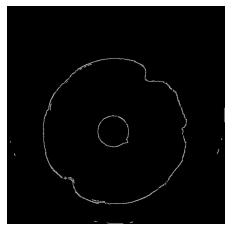

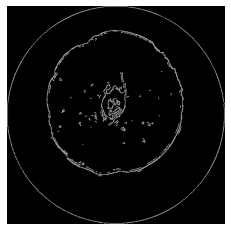

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

def gaussian_create():
    sigma1 = sigma2 = 1
    gaussian_sum = 0
    g = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            g[i, j] = math.exp(-1 / 2 * (np.square(i - 1) / np.square(sigma1)
                                         + (np.square(j - 1) / np.square(sigma2)))) / (
                              2 * math.pi * sigma1 * sigma2)
            gaussian_sum = gaussian_sum + g[i, j]
    g = g / gaussian_sum  # 归一化
    return g

def gray_fuc(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def gaussian_blur(gray_img, g):
    gray_img = np.pad(gray_img, ((1, 1), (1, 1)), constant_values=0)  
    h, w = gray_img.shape
    new_gray_img = np.zeros([h - 2, w - 2])
    for i in range(h - 2):
        for j in range(w - 2):
            new_gray_img[i, j] = np.sum(gray_img[i:i + 3, j:j + 3] * g)
    return new_gray_img

def partial_derivative(new_gray_img):
    new_gray_img = np.pad(new_gray_img, ((0, 1), (0, 1)), constant_values=0)  
    h, w = new_gray_img.shape
    dx_gray = np.zeros([h - 1, w - 1])  
    dy_gray = np.zeros([h - 1, w - 1])  
    df_gray = np.zeros([h - 1, w - 1])  
    for i in range(h - 1):
        for j in range(w - 1):
            dx_gray[i, j] = new_gray_img[i, j + 1] - new_gray_img[i, j]
            dy_gray[i, j] = new_gray_img[i + 1, j] - new_gray_img[i, j]
            df_gray[i, j] = np.sqrt(np.square(dx_gray[i, j]) + np.square(dy_gray[i, j]))
    return dx_gray, dy_gray, df_gray

def non_maximum_suppression(dx_gray, dy_gray, df_gray):
    df_gray = np.pad(df_gray, ((1, 1), (1, 1)), constant_values=0)
    h, w = df_gray.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if df_gray[i, j] != 0:
                gx = math.fabs(dx_gray[i - 1, j - 1])
                gy = math.fabs(dy_gray[i - 1, j - 1])
                if gx > gy:
                    weight = gy / gx
                    grad1 = df_gray[i + 1, j]
                    grad2 = df_gray[i - 1, j]
                    if gx * gy > 0:
                        grad3 = df_gray[i + 1, j + 1]
                        grad4 = df_gray[i - 1, j - 1]
                    else:
                        grad3 = df_gray[i + 1, j - 1]
                        grad4 = df_gray[i - 1, j + 1]
                else:
                    weight = gx / gy
                    grad1 = df_gray[i, j + 1]
                    grad2 = df_gray[i, j - 1]
                    if gx * gy > 0:
                        grad3 = df_gray[i + 1, j + 1]
                        grad4 = df_gray[i - 1, j - 1]
                    else:
                        grad3 = df_gray[i + 1, j - 1]
                        grad4 = df_gray[i - 1, j + 1]
                t1 = weight * grad1 + (1 - weight) * grad3
                t2 = weight * grad2 + (1 - weight) * grad4
                if df_gray[i, j] > t1 and df_gray[i, j] > t2:
                    df_gray[i, j] = df_gray[i, j]
                else:
                    df_gray[i, j] = 0
    return df_gray

def double_threshold(df_gray, low, high):
    h, w = df_gray.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if df_gray[i, j] < low:
                df_gray[i, j] = 0
            elif df_gray[i, j] > high:
                df_gray[i, j] = 1
            elif (df_gray[i, j - 1] > high) or (df_gray[i - 1, j - 1] > high) or (
                    df_gray[i + 1, j - 1] > high) or (df_gray[i - 1, j] > high) or (df_gray[i + 1, j] > high) or (
                    df_gray[i - 1, j + 1] > high) or (df_gray[i, j + 1] > high) or (df_gray[i + 1, j + 1] > high):
                df_gray[i, j] = 1
            else:
                df_gray[i, j] = 0
    return df_gray


if __name__ == '__main__':
    gaussian = gaussian_create()
    #generate gray pic
    gray = slice1_norm
    new_gray = gaussian_blur(gray, gaussian)
    d = partial_derivative(new_gray)
    dx = d[0]
    dy = d[1]
    df = d[2]
    new_df = non_maximum_suppression(dx, dy, df)
    #convert to 0 or 1
    low_threshold = 0.15 * np.max(new_df)
    high_threshold = 0.2 * np.max(new_df)
    result = double_threshold(new_df, low_threshold, high_threshold)
    print(result.shape)
#     print(result[250])
    #output figure
    plt.imshow(result, cmap="gray")
    plt.axis("off")
    plt.show()
    
    gray = slice2_norm
    new_gray = gaussian_blur(gray, gaussian)
    d = partial_derivative(new_gray)
    dx = d[0]
    dy = d[1]
    df = d[2]
    new_df = non_maximum_suppression(dx, dy, df)
    low_threshold = 0.15 * np.max(new_df)
    high_threshold = 0.2 * np.max(new_df)
    result2 = double_threshold(new_df, low_threshold, high_threshold)
#     print(result2[250])
    plt.imshow(result2, cmap="gray")
    plt.axis("off")
    plt.show()

# save the 0 1 format data

In [9]:
import numpy as np
np.save('testSlice1.npy',result)
np.save('testSlice2.npy',result2)

In [10]:
test1 = np.load('testSlice1.npy')
test2 = np.load('testSlice2.npy')

## dfs implementation for loss area calculated

In [11]:
import sys
sys.setrecursionlimit(100000)

In [12]:
contour_list_after = []
def dfs(grid, i, j):
    row = len(grid);
    col = len(grid[0])
    if(i<0 or j<0 or i>=row or j>=col or grid[i][j]==1):
        return
    grid[i][j] = 1
    global size
    size+=1
    #print(size)
    dfs(grid,i+1,j);
    dfs(grid,i-1,j);
    dfs(grid,i,j+1);
    dfs(grid,i,j-1);
    return;
    
    
contour_cnt = 0
#grid = [[1,1,1,1],[1,0,0,1],[1,0,0,1],[1,1,1,1]]
grid = np.array(test2)
grid = grid[200:300]
grid = grid[:,200:300]
print(grid.shape)
row = len(grid);
col = len(grid[0])
for i in range(row):
    for j in range(col):
        if(contour_cnt>10):
            break
        if(grid[i][j] == 0):
            contour_cnt+=1
            size = 0
            dfs(grid,i,j)
            contour_list_after.append(size)
            #print(size)

(100, 100)


In [13]:
print(contour_list_after)

[8926, 40, 34, 1, 1, 1, 1, 1, 1, 5, 18]


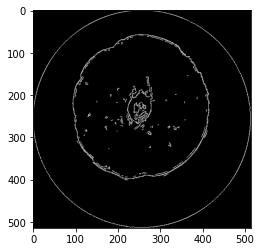

In [14]:
plt.imshow(result2, cmap="gray")

In [15]:
contour_list_before = []
def dfs(grid, i, j):
    row = len(grid);
    col = len(grid[0])
    if(i<0 or j<0 or i>=row or j>=col or grid[i][j]==1):
        return
    grid[i][j] = 1
    global size
    size+=1
    #print(size)
    dfs(grid,i+1,j);
    dfs(grid,i-1,j);
    dfs(grid,i,j+1);
    dfs(grid,i,j-1);
    return;
    
    
contour_cnt = 0
grid = np.array(test1)
grid = grid[200:300]
grid = grid[:,200:300]
print(grid.shape)
row = len(grid);
col = len(grid[0])
for i in range(row):
    for j in range(col):
        if(contour_cnt>10):
            break
        if(grid[i][j] == 0):
            contour_cnt+=1
            size = 0
            dfs(grid,i,j)
            contour_list_before.append(size)

(100, 100)


In [16]:
print(contour_list_before)

[9845, 1]


In [17]:
threshold = min(contour_list_before[0],contour_list_after[0])

In [18]:
sum_before = 0
sum_after = 0
for area in contour_list_before:
    if(area<threshold):
        sum_before += area

for area in contour_list_after:
    if(area<threshold):
        sum_after += area

sum_diff = sum_after - sum_before
print(sum_diff)

102


## complete algorithm pipeline is as below

## import package

In [19]:
import math
import matplotlib.pyplot as plt
import pydicom
import numpy
import numpy as np
import cv2
import os
import pylab
import matplotlib.image as mpimg
import sys
import glob
from scipy import ndimage
from skimage import morphology

sys.setrecursionlimit(100000)

## detect the contour

In [20]:
def gaussian_create():
    sigma1 = sigma2 = 1
    gaussian_sum = 0
    g = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            g[i, j] = math.exp(-1 / 2 * (np.square(i - 1) / np.square(sigma1)
                                         + (np.square(j - 1) / np.square(sigma2)))) / (
                              2 * math.pi * sigma1 * sigma2)
            gaussian_sum = gaussian_sum + g[i, j]
    g = g / gaussian_sum  # 归一化
    return g

def gray_fuc(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def gaussian_blur(gray_img, g):
    gray_img = np.pad(gray_img, ((1, 1), (1, 1)), constant_values=0)  
    h, w = gray_img.shape
    new_gray_img = np.zeros([h - 2, w - 2])
    for i in range(h - 2):
        for j in range(w - 2):
            new_gray_img[i, j] = np.sum(gray_img[i:i + 3, j:j + 3] * g)
    return new_gray_img

def partial_derivative(new_gray_img):
    new_gray_img = np.pad(new_gray_img, ((0, 1), (0, 1)), constant_values=0)  
    h, w = new_gray_img.shape
    dx_gray = np.zeros([h - 1, w - 1])  
    dy_gray = np.zeros([h - 1, w - 1])  
    df_gray = np.zeros([h - 1, w - 1])  
    for i in range(h - 1):
        for j in range(w - 1):
            dx_gray[i, j] = new_gray_img[i, j + 1] - new_gray_img[i, j]
            dy_gray[i, j] = new_gray_img[i + 1, j] - new_gray_img[i, j]
            df_gray[i, j] = np.sqrt(np.square(dx_gray[i, j]) + np.square(dy_gray[i, j]))
    return dx_gray, dy_gray, df_gray

def non_maximum_suppression(dx_gray, dy_gray, df_gray):
    df_gray = np.pad(df_gray, ((1, 1), (1, 1)), constant_values=0)
    h, w = df_gray.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if df_gray[i, j] != 0:
                gx = math.fabs(dx_gray[i - 1, j - 1])
                gy = math.fabs(dy_gray[i - 1, j - 1])
                if gx > gy:
                    weight = gy / gx
                    grad1 = df_gray[i + 1, j]
                    grad2 = df_gray[i - 1, j]
                    if gx * gy > 0:
                        grad3 = df_gray[i + 1, j + 1]
                        grad4 = df_gray[i - 1, j - 1]
                    else:
                        grad3 = df_gray[i + 1, j - 1]
                        grad4 = df_gray[i - 1, j + 1]
                else:
                    weight = gx / gy
                    grad1 = df_gray[i, j + 1]
                    grad2 = df_gray[i, j - 1]
                    if gx * gy > 0:
                        grad3 = df_gray[i + 1, j + 1]
                        grad4 = df_gray[i - 1, j - 1]
                    else:
                        grad3 = df_gray[i + 1, j - 1]
                        grad4 = df_gray[i - 1, j + 1]
                t1 = weight * grad1 + (1 - weight) * grad3
                t2 = weight * grad2 + (1 - weight) * grad4
                if df_gray[i, j] > t1 and df_gray[i, j] > t2:
                    df_gray[i, j] = df_gray[i, j]
                else:
                    df_gray[i, j] = 0
    return df_gray

def double_threshold(df_gray, low, high):
    h, w = df_gray.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if df_gray[i, j] < low:
                df_gray[i, j] = 0
            elif df_gray[i, j] > high:
                df_gray[i, j] = 1
            elif (df_gray[i, j - 1] > high) or (df_gray[i - 1, j - 1] > high) or (
                    df_gray[i + 1, j - 1] > high) or (df_gray[i - 1, j] > high) or (df_gray[i + 1, j] > high) or (
                    df_gray[i - 1, j + 1] > high) or (df_gray[i, j + 1] > high) or (df_gray[i + 1, j + 1] > high):
                df_gray[i, j] = 1
            else:
                df_gray[i, j] = 0
    return df_gray


def contour_detection(slice1, slice2):
    slice1_norm = np.zeros(slice1.shape, dtype=np.float32)
    slice2_norm = np.zeros(slice1.shape, dtype=np.float32)
    cv2.normalize(slice1, slice1_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    cv2.normalize(slice2, slice2_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    gaussian = gaussian_create()
    gray = slice1_norm
    new_gray = gaussian_blur(gray, gaussian)
    d = partial_derivative(new_gray)
    dx = d[0]
    dy = d[1]
    df = d[2]
    new_df = non_maximum_suppression(dx, dy, df)
    #convert to 0 or 1
    low_threshold = 0.15 * np.max(new_df)
    high_threshold = 0.2 * np.max(new_df)
    result = double_threshold(new_df, low_threshold, high_threshold)
    
    gray = slice2_norm
    new_gray = gaussian_blur(gray, gaussian)
    d = partial_derivative(new_gray)
    dx = d[0]
    dy = d[1]
    df = d[2]
    new_df = non_maximum_suppression(dx, dy, df)
    low_threshold = 0.15 * np.max(new_df)
    high_threshold = 0.2 * np.max(new_df)
    result2 = double_threshold(new_df, low_threshold, high_threshold)
    
    print("finish detecting the contour\n")
    return result, result2

## dfs algorithm to calculate the small loss area

In [21]:
def dfs(grid, i, j):
    row = len(grid);
    col = len(grid[0])
    if(i<0 or j<0 or i>=row or j>=col or grid[i][j]==1):
        return
    grid[i][j] = 1
    global size
    size+=1
    #print(size)
    dfs(grid,i+1,j);
    dfs(grid,i-1,j);
    dfs(grid,i,j+1);
    dfs(grid,i,j-1);
    return;

'''
single slice calculation
'''
def slice_loss(metaslice1,metaslice2):
    slice1, slice2 = contour_detection(metaslice1, metaslice2)
    contour_list_after = []
    contour_list_before = []
    contour_cnt = 0
    grid = np.array(slice2)
    grid = grid[200:300]
    grid = grid[:,200:300]
    row = len(grid);
    col = len(grid[0])
    for i in range(row):
        for j in range(col):
            if(contour_cnt>10):
                break
            if(grid[i][j] == 0):
                contour_cnt+=1
                global size
                size = 0
                dfs(grid,i,j)
                contour_list_after.append(size)
    contour_cnt = 0
    grid = np.array(slice1)
    grid = grid[200:300]
    grid = grid[:,200:300]
    row = len(grid);
    col = len(grid[0])
    for i in range(row):
        for j in range(col):
            if(contour_cnt>10):
                break
            if(grid[i][j] == 0):
                contour_cnt+=1
                size = 0
                dfs(grid,i,j)
                contour_list_before.append(size)
    print("area in pre test")
    print(contour_list_after)
    print("area in post test")
    print(contour_list_before)
    
    sum_before = 0
    sum_after = 0
    for area in contour_list_before:
        if(area<threshold):
            sum_before += area

    for area in contour_list_after:
        if(area<threshold):
            sum_after += area

    sum_diff = sum_after - sum_before
    return sum_diff

# metaslice1 = img3d[:, :, img_shape[2]//4]
# metaslice2 = img3d_2[:, :, img_shape[2]//4]
# sliceLoss = slice_loss(metaslice1,metaslice2)
# print("loss = ",sliceLoss)
# print("\n")

## calculate the whole volume loss by integrating each slice loss

In [ ]:
'''
prepare the data, read from dcm file directory
'''
def read_dcm(directory):
    # load the DICOM files
    files = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        files.append(pydicom.dcmread(f))

    print("file count: {}".format(len(files)))

    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'SliceLocation'):
            slices.append(f)
        else:
            skipcount = skipcount + 1

    print("skipped, no SliceLocation: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    return slices


'''
create 3d array
'''
def create_array(slices1, slices2):
    ps = slices1[0].PixelSpacing
    ss = slices1[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]
    img_shape = list(slices1[0].pixel_array.shape)
    img_shape.append(len(slices1))
    img3d = np.zeros(img_shape)
    img3d_2 = np.zeros(img_shape)
    # fill 3D array with the images from the files
    for i, s in enumerate(slices1):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d
        
    for i, s in enumerate(slices2):
        img2d = s.pixel_array
        img3d_2[:, :, i] = img2d
    print("finish creating 3d array\n")
    return img3d, img3d_2,ps, ss

'''
calculate the volume loss
'''
def cal_vol_loss(img3d, img3d_2, ps, thick):
    vol_loss = 0
    for i in range(0,img_shape[2]):
        metaslice1 = img3d[:, :, i]
        metaslice2 = img3d_2[:, :, i]
        print('\n')
        print("calculate loss of slice",i)
        sliceLoss = slice_loss(metaslice1,metaslice2)
        print("\nloss = ",sliceLoss)
        loss_actual_size = sliceLoss * ps[0] * ps[1] * 0.001 * 0.001
        vol_loss += loss_actual_size * thick * 0.001
        print("current integration volume loss is",vol_loss,"m^3")
    return vol_loss
        
        
if __name__ == '__main__':
    directory1 = "./Pre Test CT Scan/Series-431_11226 Core 1/"
    directory2 = "./Post Test CT Scans/Series-470_22-J2_11226_ATWC 2"
    slices1 = read_dcm(directory1)
    print("finished loading pre test")
    slices2 = read_dcm(directory2)
    print("finished loading post test")
    img3d, img3d_2, ps, thick= create_array(slices1, slices2)
    cal_vol_loss(img3d, img3d_2, ps, thick)

file count: 401
skipped, no SliceLocation: 0
finished loading pre test
file count: 401
skipped, no SliceLocation: 0
finished loading post test
finish creating 3d array



calculate loss of slice 0
finish detecting the contour

area in pre test
[10000]
area in post test
[10000]

loss =  0
current integration volume loss is 0.0 m^3


calculate loss of slice 1
finish detecting the contour

area in pre test
[10000]
area in post test
[10000]

loss =  0
current integration volume loss is 0.0 m^3


calculate loss of slice 2
finish detecting the contour

area in pre test
[10000]
area in post test
[10000]

loss =  0
current integration volume loss is 0.0 m^3


calculate loss of slice 3
finish detecting the contour

area in pre test
[10000]
area in post test
[10000]

loss =  0
current integration volume loss is 0.0 m^3


calculate loss of slice 4
finish detecting the contour

area in pre test
[10000]
area in post test
[10000]

loss =  0
current integration volume loss is 0.0 m^3


calculate loss